In [1]:
# I only need the following line since I'm using remote VS Code
%cd "/arc/home/IsaacCheng/CASTOR/ETC/notebooks"

import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display

# Import my own modules
import sys
sys.path.append("../")
from castor_etc import filepaths as fp

/arc/home/IsaacCheng/CASTOR/ETC/notebooks


## Check that my blackbody generation is correct

(This is implemented in a unit test now!)


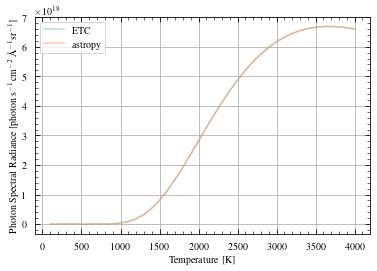

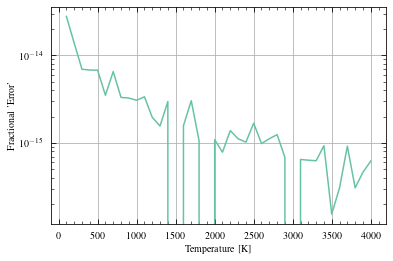

My BB == Astropy BB? True


In [2]:
from astropy.modeling.models import BlackBody
from castor_etc.spectrum import generate_BB
from castor_etc.conversions import calc_photon_energy

# My blackbody model
wavelengths, spectrum = generate_BB(
    T=10000, limits=[100, 4000] * u.AA, resolution=100 * u.AA
)
# Astropy blackbody model
bb = BlackBody(10000 * u.K)
spectrum2 = bb(wavelengths * u.AA).to(
    u.erg / (u.s * u.cm ** 2 * u.AA * u.sr),
    equivalencies=u.spectral_density(wavelengths * u.AA),
)
spectrum2 /= (wavelengths * u.AA).to(u.erg, equivalencies=u.spectral())

fig, ax = plt.subplots()
ax.plot(wavelengths, spectrum, label="ETC", alpha=0.5)
ax.plot(wavelengths, spectrum2, label="astropy", alpha=0.5)
ax.legend()
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(
    r"Photon Spectral Radiance [photon\,s$^{-1}$\,cm$^{-2}$\,\AA$^{-1}$sr$^{-1}$]"
)
plt.show()

fig, ax = plt.subplots()
ax.plot(wavelengths, abs(spectrum2.value - spectrum) / spectrum2.value)
ax.semilogy()
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Fractional 'Error'")
plt.show()

print("My BB == Astropy BB?", np.allclose(spectrum, spectrum2.value, atol=1e-15))


## Calculate red leak for HST WFC3 F218W filter

Compare ETC red leak calculations vs. those from the WFC3 Instrument Handbook.


In [2]:
from astropy.io import fits

from castor_etc.spectrum import generate_BB
from castor_etc.conversions import calc_photon_energy

f218, f218_header = fits.getdata(
    fp.DATAPATH + "wfc3uvis1_f218w_008_syn.fits", header=True
)
f218_wavelength, f218_throughput = f218.field(0), f218.field(1)
# print(f218_wavelength)
# print(f218_throughput)
display(f218_header)

hst_redleaks = pd.read_csv(fp.DATAPATH + "hst_redleak.txt", sep="\t", header=0)
with pd.option_context("display.float_format", "{:.1e}".format):
    display(hst_redleaks)


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                  460 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'WAVELENGTH'                                                          
TFORM1  = 'E       '                                                            
TUNIT1  = 'ANGSTROMS'                                                           
TTYPE2  = 'THROUGHPUT'                                                          
TFORM2  = 'E       '        

,T_eff,F218W,F225W,F275W,F300X,F336W
0,1000,1.0e+00,1.0e+00,1.0e+00,1.0e+00,1.0e+00
1,2000,9.9e-01,9.9e-01,8.4e-01,5.5e-01,3.0e-02
2,3000,6.0e-01,2.7e-01,3.0e-02,8.9e-02,8.4e-04
3,4000,1.1e-01,1.8e-02,3.1e-03,3.3e-02,1.4e-04
4,5000,2.7e-02,3.2e-03,8.6e-04,1.7e-02,4.5e-05
5,6000,9.9e-03,1.0e-03,3.8e-04,1.0e-02,2.2e-05
6,7000,4.9e-03,4.6e-04,2.2e-04,7.3e-03,1.3e-05
7,8000,2.8e-03,2.5e-04,1.5e-04,5.5e-03,9.0e-06
8,9000,1.9e-03,1.6e-04,1.1e-04,4.4e-03,6.8e-06
9,10000,1.3e-03,1.1e-04,8.6e-05,3.7e-03,5.4e-06


In [3]:
bb_temps = hst_redleaks["T_eff"].values

f218_spectrums = []
f218_detections = []
f218_redleaks = []

is_redleak = f218_wavelength > 4000.0

for temp in bb_temps:
    # f218_spectrum = (
    #     generate_BB(T=temp, wavelengths=f218_wavelength)[1]  # photons/s/cm^2/A/sr
    #     * calc_photon_energy(wavelength=f218_wavelength)[0]  # to erg/s/cm^2/A/sr
    # )

    # (NOTE re: above) Cannot use spectral radiance. Must use _photon_ spectral radiance
    # for convolution with HST throughput curve!

    f218_spectrum = generate_BB(T=temp, wavelengths=f218_wavelength)[1]  # photons/s/cm^2/A/sr
    f218_detection = f218_throughput * f218_spectrum
    f218_redleaks.append(np.sum(f218_detection[is_redleak]) / np.sum(f218_detection))
    f218_spectrums.append(f218_spectrum)
    f218_detections.append(f218_detection)

df = pd.DataFrame(f218_redleaks, index=bb_temps, columns=["redleak"])

with pd.option_context("display.float_format", "{:.1e}".format):
    display(df)

# ---------------------------------------------------------------------------------------#
# Results agree at low temps but get increasingly worse as temp increases...
# Uh oh... 21st century ultraviolet catastrophe?! O_o

# I have checked my BB function and calc_photon_energy function against astropy; they
# agree to within 1e-13 & 1e-15 (nearly the floating-point limit of IEEE 754!).

# I'm guessing it must be slightly different throughput curves or, more likely, slightly
# different values for constants (e.g., Planck's constant, Boltzmann constant, speed of
# light) that is causing this temperature-dependent discrepancy...
# ---------------------------------------------------------------------------------------#

,redleak
1000,1.0e+00
2000,1.0e+00
3000,6.8e-01
4000,1.0e-01
5000,2.2e-02
6000,7.6e-03
7000,3.6e-03
8000,2.0e-03
9000,1.3e-03
10000,9.4e-04


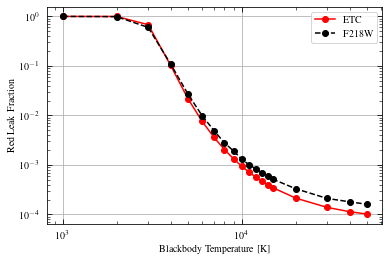

In [4]:
fig, ax = plt.subplots()
ax.plot(bb_temps, f218_redleaks, "ro-", label="ETC")
# ax.plot(bb_temps, 2 * np.array(f218_redleaks), "bo-", label=r"$2\times$ETC")
ax.plot(bb_temps, hst_redleaks["F218W"], "ko--", label="F218W")
ax.legend()
ax.loglog()
ax.set_xlabel("Blackbody Temperature [K]")
ax.set_ylabel("Red Leak Fraction")
plt.show()


Greatest abs(relative err): 36.907059%


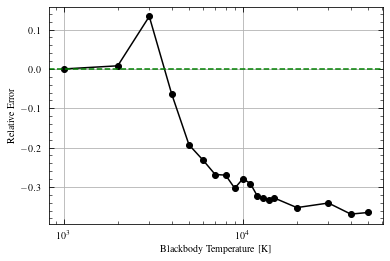

In [5]:
relative_err = (np.array(f218_redleaks) - hst_redleaks["F218W"].values) / (
    hst_redleaks["F218W"].values
)

print(f"Greatest abs(relative err): {np.max(abs(relative_err)):%}")

fig, ax = plt.subplots()
ax.plot(bb_temps, relative_err, "ko-")
ax.set_xlabel("Blackbody Temperature [K]")
ax.set_ylabel("Relative Error")
ax.semilogx()
ax.axhline(0, c="g", ls="--")
plt.show()


## Recalculate red leak

Compare results against Table 3-5 of CASTOR Science Maturation Study.


In [2]:
from castor_etc import constants as const
from castor_etc.spectrum import redshift_wavelengths


def norm_to_star(spectrum, radius=1, dist=1 << u.kpc):
    """
    Normalize the blackbody spectrum to a star of given radius and distance. By
    default, normalizes the flux to a star of 1 solar radius at 1 kpc. Reference:
    <https://github.com/spacetelescope/pysynphot/blob/925cdbac35a7851cee1bddaa2b47651235c44851/pysynphot/spectrum.py#L40>.

    Note that the spectrum's units should have a unit of steradian (sr) in the
    denominator, which will be multiplied out (e.g., erg/s/cm^2/A/sr).

    Parameters
    ----------
      spectrum :: array of floats
        The spectrum to normalize. It should have a unit of steradian in the
        denominator.

      radius :: float or `astropy.Quantity` length
        The radius of the source. If a scalar, it is assumed to be in units of solar
        radii.

      dist :: float or `astropy.Quantity` length
        The distance to the blackbody. If a scalar, it is assumed to be in units of
        kpc.

    Returns
    ----------
      norm_spectrum :: array of floats
        Spectrum normalized such that the unit of steradian in the denominator
        vanishes.
    """
    #
    # Check inputs
    #
    if not isinstance(radius, u.Quantity):
        radius = radius * const.SUN_RADIUS  # cm
    if not isinstance(dist, u.Quantity):
        dist = dist * u.kpc
    radius = radius.to(u.km).value
    dist = dist.to(u.km).value
    #
    # Normalize spectrum
    #
    radian = radius / dist
    return spectrum * np.pi * radian * radian  # multiply by projected solid angle


def generate_bb(
    T,
    redshift=0.0,
    emissivity=1.0,
    wavelengths=None,
    limits=[0.1, 1.2] << u.um,
    resolution=1 << u.nm,
    radius=1,
    dist=1 << u.kpc,
):
    """
    Generate a blackbody (BB) spectrum (in erg/s/cm^2/A) using Planck's radiation law.
    The spectral radiance of the BB (erg/s/cm^2/A/sr) is normalized to a star of given
    radius and distance.

    Parameters
    ----------
        T :: int or float or `astropy.Quantity`
        Intrinsic blackbody temperature (i.e., the temperature of the BB at
        redshift=0). If int or float, the unit is assumed to be kelvin.

        redshift :: int or float
        Redshift of the blackbody.

        emissivity :: int or float
        Emissivity of the blackbody. (Technically, emissivity is unity per the
        definition of a BB).

        wavelengths :: array of floats or `astropy.Quantity` array
        The wavelengths over which to calculate the spectrum. If an array of floats,
        the unit is assumed to be in angstroms. If wavelengths is not None, the limits
        and resolution parameters are ignored. Note that the final wavelengths
        attribute will be an `astropy.Quantity` array in units of angstroms regardless
        of this input's units.

        limits :: list of 2 scalars or list of 2 `astropy.Quantity`
        List containing the lower (0th index) and upper (1st index) bounds for the BB
        spectrum's restframe wavelengths, inclusive. Limits should be > 0. If list
        elements are int or float, they are assumed to be in angstroms. This parameter
        is ignored if wavelengths is provided.

        resolution :: int or float or `astropy.Quantity`
        The wavelength resolution of the returned spectrum. If a scalar, it is assumed
        to be in units of angstroms. This parameter is ignored if wavelengths is
        provided.

        radius :: float or `astropy.Quantity`
        The radius of the source. If a scalar, it is assumed to be in units of solar
        radii.

        dist :: float or `astropy.Quantity`
        The distance to the blackbody. If a scalar, it is assumed to be in units of
        kpc.

    Attributes
    ----------
        wavelengths :: `astropy.Quantity` array
        The redshifted wavelengths of the spectrum, in angstroms.

        spectrum :: array of floats
        BB spectrum in units of flam (erg/s/cm^2/A).

    Returns
    -------
        None
    """
    #
    # Check inputs
    #
    if isinstance(T, u.Quantity):
        T = T.to(u.K, equivalencies=u.temperature()).value
    if wavelengths is None:
        limits = list(limits)
        for i, lim in enumerate(limits):
            if isinstance(lim, u.Quantity):
                limits[i] = lim.to(u.AA).value
        if isinstance(resolution, u.Quantity):
            resolution = resolution.to(u.AA).value
        wavelengths = np.arange(limits[0], limits[1] + 0.5 * resolution, resolution)
    elif isinstance(wavelengths, u.Quantity):
        wavelengths = wavelengths.to(u.AA).value
    #
    # Generate BB spectrum with redshift
    #
    # Factor in redshift & convert wavelengths from angstrom to cm
    wavelengths = redshift_wavelengths(wavelengths, redshift) * 1e-8  # cm
    # Planck's radiation law
    lightspeed = const.LIGHTSPEED.value  # cm/s
    prefactor = (2 * const.PLANCK_H.value * lightspeed * lightspeed) / (wavelengths ** 5)
    denom = np.expm1(
        (const.PLANCK_H.value * lightspeed) / (wavelengths * const.K_B.value * T)
    )
    spectrum = prefactor / denom  # erg/s/cm^2/cm/sr
    #
    # Incorporate emissivity and convert per cm to per angstrom
    #
    spectrum *= 1e-8 * emissivity  # erg/s/cm^2/A/sr
    #
    # Convert wavelengths back to angstroms
    #
    wavelengths *= 1e8  # angstrom
    #
    # Assign to `Source` object attributes. Spectrum is in erg/s/cm^2/A
    #
    wavelengths = wavelengths * u.AA
    spectrum = norm_to_star(spectrum, radius=radius, dist=dist)  # flam
    return wavelengths, spectrum


### Generate BB spectrum


In [3]:
#
# Load Table 3-5
#
tab35 = pd.read_csv(
    fp.DATAPATH + "/SMS_table_3-5.txt",
    sep=" ",
    header=0,
    comment="#",
)
tab35

,T_eff,uv,u,g
0,3000,0.36000,9.800000e-06,1.600000e-11
1,4000,0.06100,3.900000e-06,1.100000e-11
2,5000,0.02300,2.200000e-06,8.800000e-12
3,7000,0.00780,1.200000e-06,6.600000e-12
4,10000,0.00340,7.600000e-07,5.400000e-12
5,15000,0.00180,5.500000e-07,4.600000e-12
6,20000,0.00130,4.700000e-07,4.300000e-12
7,30000,0.00095,4.100000e-07,4.000000e-12
8,40000,0.00082,3.900000e-07,3.900000e-12
9,50000,0.00075,3.700000e-07,3.800000e-12


In [4]:
from castor_etc import parameters as params
from castor_etc.load_files import load_passbands
from castor_etc.conversions import calc_photon_energy

RESOLUTION = 1 << u.AA
WAVELENGTH_LIMITS = {band: [0.1, 1.1] << u.um for band in params.PASSBANDS}  # load entire passband response
passband_response = load_passbands(
    filters="all",
    limits=WAVELENGTH_LIMITS,
    resolution=RESOLUTION,
    kind="linear",
)
# bb_temps = [3000, 4000, 5000, 7000, 10000, 15000, 20000, 30000, 40000, 50000]  # kelvin
bb_temps = tab35["T_eff"].values
bb_spectrums = {
    band: {temp: {"erate": None} for temp in bb_temps} for band in params.PASSBANDS
}
# Common wavelengths
bb_spectrums["wavelengths"] = generate_bb(
    1000, limits=WAVELENGTH_LIMITS["uv"], resolution=RESOLUTION
)[0]

for band in params.PASSBANDS:
    for temp in bb_temps:
        # Generate BB spectrum
        photlam = generate_bb(
            temp, wavelengths=bb_spectrums["wavelengths"], resolution=RESOLUTION
        )[1] / calc_photon_energy(wavelength=bb_spectrums["wavelengths"])[0]  # photon/s/cm^2/A

        # Multiply by mirror area --> photon/s/A (multiplying by constant)
        photon_rate_per_AA = photlam * params.MIRROR_AREA.value

        # Convolve with passband response --> electron/s
        bb_spectrums[band][temp]["erate"] = (
            photon_rate_per_AA
            * passband_response[band]["throughput"].values  # ? (maybe passband response changed) ?
            * RESOLUTION.to(u.AA).value  # (multiplying by constant)
        )


In [5]:
for band in WAVELENGTH_LIMITS:
    print(f"{band}-throughput (between {WAVELENGTH_LIMITS[band]}):")
    print(f"{'Temperature':<15} Total Electron/s")
    for temp in bb_spectrums[band]:
        print(f"{str(temp)+ 'K':<15} {np.nansum(bb_spectrums[band][temp]['erate']):e}")
    print()


uv-throughput (between [0.1 1.1] um):
Temperature     Total Electron/s
3000K           1.258973e-01
4000K           4.016211e+00
5000K           5.064529e+01
7000K           1.230283e+03
10000K          1.585840e+04
15000K          1.292465e+05
20000K          3.899629e+05
30000K          1.271281e+06
40000K          2.444486e+06
50000K          3.772780e+06

u-throughput (between [0.1 1.1] um):
Temperature     Total Electron/s
3000K           3.422923e+00
4000K           9.359609e+01
5000K           7.038884e+02
7000K           7.321391e+03
10000K          4.398516e+04
15000K          1.870003e+05
20000K          4.045748e+05
30000K          9.543084e+05
40000K          1.574540e+06
50000K          2.226371e+06

g-throughput (between [0.1 1.1] um):
Temperature     Total Electron/s
3000K           6.104353e+01
4000K           7.020873e+02
5000K           3.112336e+03
7000K           1.760379e+04
10000K          6.741726e+04
15000K          2.058483e+05
20000K          3.823104e+05
3000

### Calculate red leak from spectrum

Note that the red leak definition in Table 3-5 is slightly different from the definition
used in the WFC3 Instrument Handbook. In the WFC3 Handbook, they define "red leak" as any
detection longward of 4000A. They then give the ratio of this red leak to the _total_
flux as the "red leak fraction".

In Table 3-5, they defined red leak as the fraction of flux beyond the furthest edge
(i.e., the longest wavelength) of the passband* compared to the flux within the passband
range. This is why some "red leak fractions" in Table 3-5 are greater than 1 (e.g., the
HST/WFC3 F218W red leak fraction for a star of T_eff=3000K).

\* We chose these "threshold" wavelengths by eye. They are slightly greater than the
passband limit wavelength since the passband does not exactly end at their nominal values.


In [6]:
bb_redleaks = {
    band: {
        temp: {
            "tot_erate": None,
            "passband_erate": None,
            "redleak": None,
            "redleak_frac": None,
        }
        for temp in bb_temps
    }
    for band in params.PASSBANDS
}

# redleak_threshold = {"uv": 3900, "u": 4700, "g": 5650}  # angstrom (for 1 nm resolution)
redleak_threshold = {"uv": 3880, "u": 4730, "g": 5660}  # angstrom (for 1 AA resolution)

for band in bb_redleaks:
    print(f"{band}-band limit:", redleak_threshold[band])

    is_in_passband = (
        bb_spectrums["wavelengths"].value >= params.PASSBAND_LIMITS[band][0].to(u.AA).value
    ) & (bb_spectrums["wavelengths"].value <= params.PASSBAND_LIMITS[band][1].to(u.AA).value)

    # is_redleak = (
    #     bb_spectrums["wavelengths"]
    #     > params.PASSBAND_LIMITS[band][1].to(u.AA).value
    # )
    is_redleak = bb_spectrums["wavelengths"].value > redleak_threshold[band]
    # NOTE: I tried shifting the passband limit above but it still doesn't get us
    # that close to Table 3-5

    for temp in bb_redleaks[band]:
        tot_erate = np.nansum(bb_spectrums[band][temp]["erate"])
        passband_erate = np.nansum(bb_spectrums[band][temp]["erate"][is_in_passband])
        redleak = np.nansum(bb_spectrums[band][temp]["erate"][is_redleak])

        bb_redleaks[band][temp]["tot_erate"] = tot_erate
        bb_redleaks[band][temp]["passband_erate"] = passband_erate
        bb_redleaks[band][temp]["redleak"] = redleak
        # bb_redleaks[band][temp]["redleak_frac"] = redleak / tot_erate
        bb_redleaks[band][temp]["redleak_frac"] = redleak / passband_erate


uv-band limit: 3880
u-band limit: 4730
g-band limit: 5660


In [7]:
for band in bb_redleaks:
    print(f"{band}-band:")
    print(f"{'Temperature':<15} Red Leak Fraction")
    for temp in bb_redleaks[band]:
        print(f"{str(temp)+ 'K':<15} {bb_redleaks[band][temp]['redleak_frac']:e}")
    print()


uv-band:
Temperature     Red Leak Fraction
3000K           2.987512e+00
4000K           3.631858e-01
5000K           1.004098e-01
7000K           2.206991e-02
10000K          6.761035e-03
15000K          2.646208e-03
20000K          1.669847e-03
30000K          1.077656e-03
40000K          8.783235e-04
50000K          7.817474e-04

u-band:
Temperature     Red Leak Fraction
3000K           1.773042e-05
4000K           6.164665e-06
5000K           3.210275e-06
7000K           1.503909e-06
10000K          8.562050e-07
15000K          5.654369e-07
20000K          4.668388e-07
30000K          3.914872e-07
40000K          3.610296e-07
50000K          3.447615e-07

g-band:
Temperature     Red Leak Fraction
3000K           1.590182e-11
4000K           1.107666e-11
5000K           8.752506e-12
7000K           6.597523e-12
10000K          5.328684e-12
15000K          4.548317e-12
20000K          4.225296e-12
30000K          3.945845e-12
40000K          3.821942e-12
50000K          3.752506e-12



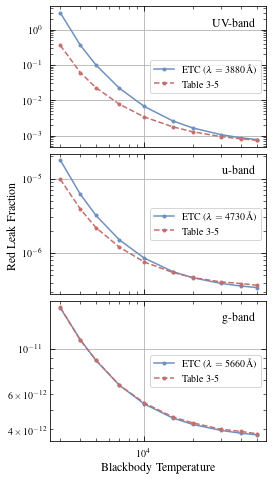

In [7]:
#
# Plot comparison of Table 3-5 to our red leak values
#
plot_params = {
    # Colours
    "etc": sns.color_palette("vlag")[0],
    "tab35": sns.color_palette("vlag")[-1],
}

fig, axs = plt.subplots(nrows=3, sharex=True, figsize=mpl.figure.figaspect(2))
for band, ax in zip(bb_redleaks, axs):
    ax.plot(
        bb_temps,
        [bb_redleaks[band][temp]["redleak_frac"] for temp in bb_temps],
        ls="-",
        color=plot_params["etc"],
        marker=".",
        label=f"ETC ($\\lambda={redleak_threshold[band]}\,$\AA)",
    )
    ax.plot(
        tab35["T_eff"],
        tab35[band],
        ls="--",
        color=plot_params["tab35"],
        marker=".",
        label="Table~3-5",
    )
    if band == "uv":
        band = band.upper()
    ax.text(
        0.95, 0.86, band + "-band", c="k", ha="right", transform=ax.transAxes, fontsize=12
    )
    ax.loglog()
    # ax.set_xlim(left=1000)
    ax.legend(loc="center right")

ax.set_xlabel("Blackbody Temperature", fontsize=12)
fig.text(
    0.0,
    0.5,
    "Red Leak Fraction",
    va="center",
    rotation="vertical",
    fontsize=12,
)
fig.subplots_adjust(left=0.15, hspace=0.05)
fig.savefig(fp.OUTPATH + "redleak.pdf")
plt.show()
